# Notebook 03 — Label Construction & Crisis Alignment

This notebook takes the **stress index** computed in Notebook 02 and turns it
into **binary stress labels** (0 = no stress, 1 = stress). It also checks
whether the detected stress periods line up with well-known stress episodes
in financial markets and performs **robustness checks** using alternative
labeling methods.

**Goals:**

1. **Load the stress index** from `data/processed/stress_index.csv`.

2. **Choose a metric to label**:
   - Prefer `stress_index_smooth` if available, otherwise use `stress_index`.

3. **Main labeling method**:
   - Use the 95th percentile (top 5%) of the stress index as a threshold.
   - Label days with index ≥ threshold as stress days (1), others as 0.
   - Save these labels to `data/processed/stress_labels.csv`.
   - Plot the stress index, the threshold, and the labeled stress days.

4. **Crisis alignment check**:
   - Compare labeled stress days to known crisis windows:
     - Global Financial Crisis (2007–2009)
     - Eurozone sovereign debt crisis (2010–2012)
     - COVID crash (March–April 2020)
     - US regional bank stress (March 2023)
   - Print how many days in each window are labeled as stress.
   - Print what fraction of all stress days fall inside these windows.
   - Plot the stress index with crisis windows and stress labels highlighted.

5. **Robustness checks**:
   - Recompute labels using alternative specifications:
     - 90th percentile threshold (more lenient)
     - `combined` method from `labels.py`, integrating:
       - threshold labels  
       - ±3-day windows around event dates  
       - extended crisis windows  
   - Save alternative labels to:
     - `data/processed/stress_labels_q90.csv`
     - `data/processed/stress_labels_combined.csv`
   - Compare:
     - number of stress days  
     - overlap with the main specification  
     - visual alignment with crisis periods  

The threshold-based labels produced here (`stress_labels.csv`) are the 
**main specification** and will be used later in the model and in `main.py`.

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# The notebook lives in <project_root>/notebooks,
# so project root is the parent directory of the current one.
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Change working directory so relative paths (data/processed, results, …)
# are resolved from the project root.
os.chdir(PROJECT_ROOT)

# Ensure src/ is on sys.path so that "import bank_stress.labels" works.
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("Running from:", Path.cwd())
print("SRC_DIR:", SRC_DIR)

from bank_stress.labels import construct_labels  # noqa: E402

Running from: /files/bank_stress_detection_project_datascience_class
SRC_DIR: /files/bank_stress_detection_project_datascience_class/src


In [2]:
# --- Cell 2: Load stress index and choose metric column ---

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results" / "figures"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

STRESS_INDEX_PATH = PROCESSED_DIR / "stress_index.csv"
STRESS_LABELS_MAIN_PATH = PROCESSED_DIR / "stress_labels.csv"
STRESS_LABELS_Q90_PATH = PROCESSED_DIR / "stress_labels_q90.csv"
STRESS_LABELS_COMBINED_PATH = PROCESSED_DIR / "stress_labels_combined.csv"

if not STRESS_INDEX_PATH.exists():
    msg = f"Missing {STRESS_INDEX_PATH} — run Notebook 02 first."
    raise FileNotFoundError(msg)

stress_df = pd.read_csv(
    STRESS_INDEX_PATH,
    index_col=0,
    parse_dates=True,
).sort_index()

print("Loaded stress index shape:", stress_df.shape)
print("Columns:", list(stress_df.columns))

# Prefer smoothed index if available, otherwise raw stress_index.
if "stress_index_smooth" in stress_df.columns:
    metric_column = "stress_index_smooth"
elif "stress_index" in stress_df.columns:
    metric_column = "stress_index"
else:
    raise KeyError(
        "No 'stress_index' or 'stress_index_smooth' column found in "
        f"{STRESS_INDEX_PATH}"
    )

stress_series = stress_df[metric_column].copy()
stress_series.name = "stress_index"

# Drop NaNs (could also interpolate/ffill, but dropping is simplest)
nan_count = stress_series.isna().sum()
if nan_count:
    print(
        f"Warning: stress_series contains {nan_count} NaN values — "
        "dropping them before labeling.",
    )
stress_series = stress_series.dropna()

if stress_series.empty:
    raise ValueError(
        "stress_series is empty after dropping NaNs. "
        "Check stress_index.csv.",
    )

# Normalise timezone: make index tz-naive to avoid comparison errors later
if getattr(stress_series.index, "tz", None) is not None:
    stress_series.index = stress_series.index.tz_convert(None)

display(stress_series.head())
print("Stress index date range:", stress_series.index.min(), "→", stress_series.index.max())
print("Number of observations:", len(stress_series))
print("Using metric column:", metric_column)

Loaded stress index shape: (2355, 6)
Columns: ['avg_vol', 'avg_corr', 'z_vol', 'z_corr', 'stress_index', 'stress_index_smooth']


Date
2000-01-05 05:00:00    1.041222
2000-01-06 05:00:00    1.074678
2000-01-07 05:00:00    1.028803
2000-01-10 05:00:00    0.925065
2000-01-11 05:00:00    0.816607
Name: stress_index, dtype: float64

Stress index date range: 2000-01-05 05:00:00 → 2025-11-21 05:00:00
Number of observations: 2354
Using metric column: stress_index_smooth


In [3]:
# ---------------------------------------------------------------------
# Main specification — threshold-based labels (top 5%)
# ---------------------------------------------------------------------

LABEL_METHOD_MAIN = "threshold"
QUANTILE_MAIN = 0.95 # top 5% of stress index values

labels_df_main, threshold_value_main = construct_labels(
    stress_index=stress_series,
    method=LABEL_METHOD_MAIN,
    quantile=QUANTILE_MAIN,
    event_dates=None,
    event_window=(0, 0),
    crisis_windows=None,
)

if labels_df_main is None or labels_df_main.empty:
    raise ValueError("construct_labels returned no labels for the main spec.")

# Coerce to int 0/1 and make sure 'reason' exists
if "stress_label" not in labels_df_main.columns:
    raise KeyError("'stress_label' column missing from labels_df_main.")

labels_df_main["stress_label"] = labels_df_main["stress_label"].astype(int)

if "reason" not in labels_df_main.columns:
    labels_df_main["reason"] = np.nan

# Save to CSV
labels_df_main.to_csv(STRESS_LABELS_MAIN_PATH, index_label="Date")
print("Saved main labels to:", STRESS_LABELS_MAIN_PATH)

print("\nMain label counts (0 = non-stress, 1 = stress):")
print(labels_df_main["stress_label"].value_counts(dropna=False))

print("\nReasons summary (if present):")
print(labels_df_main["reason"].value_counts(dropna=False).head(10))

display(labels_df_main.head())
print("Main threshold value (q=0.95):", threshold_value_main)

Saved main labels to: /files/bank_stress_detection_project_datascience_class/data/processed/stress_labels.csv

Main label counts (0 = non-stress, 1 = stress):
stress_label
0    2236
1     118
Name: count, dtype: int64

Reasons summary (if present):
reason
none         2236
threshold     118
Name: count, dtype: int64


,metric_value,threshold,stress_label,reason
date,,,,
2000-01-05 05:00:00,1.041222,1.157159,0,none
2000-01-06 05:00:00,1.074678,1.157159,0,none
2000-01-07 05:00:00,1.028803,1.157159,0,none
2000-01-10 05:00:00,0.925065,1.157159,0,none
2000-01-11 05:00:00,0.816607,1.157159,0,none


Main threshold value (q=0.95): 1.1571591414707612


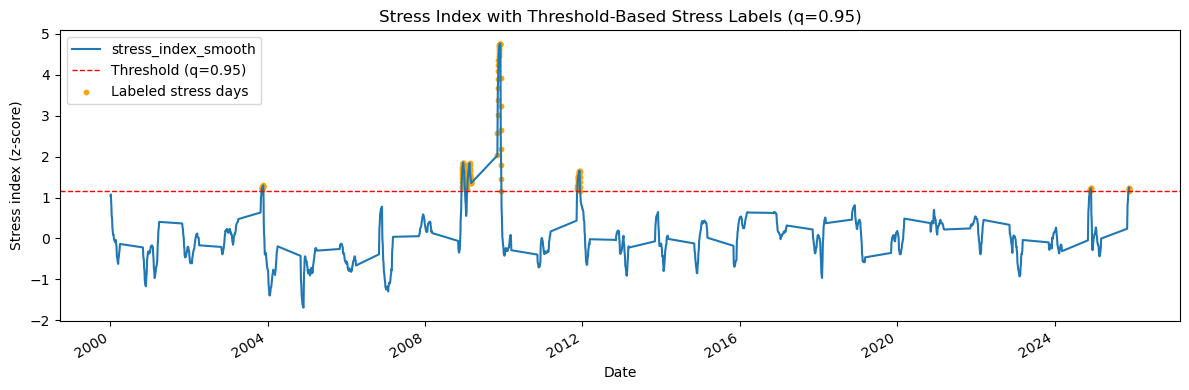

Saved main labels figure to: /files/bank_stress_detection_project_datascience_class/results/figures/stress_index_with_labels_threshold_q95.png


In [4]:
# --- Cell 4: Plot stress index with main threshold-based labels ---

fig, ax = plt.subplots(figsize=(12, 4))

stress_series.plot(ax=ax, label=metric_column, color="tab:blue")

if pd.notna(threshold_value_main):
    ax.axhline(
        y=threshold_value_main,
        color="red",
        linestyle="--",
        linewidth=1.0,
        label=f"Threshold (q={QUANTILE_MAIN:.2f})",
    )

mask_main = labels_df_main["stress_label"] == 1
ax.scatter(
    stress_series.index[mask_main],
    stress_series[mask_main],
    color="orange",
    s=10,
    label="Labeled stress days",
)

ax.set_title("Stress Index with Threshold-Based Stress Labels (q=0.95)")
ax.set_xlabel("Date")
ax.set_ylabel("Stress index (z-score)")

# Remove duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper left")

fig.tight_layout()
labels_fig_main = RESULTS_DIR / "stress_index_with_labels_threshold_q95.png"
fig.savefig(labels_fig_main, dpi=150)
plt.show()

print("Saved main labels figure to:", labels_fig_main)

In [5]:
# --- Cell 5: Robustness check 1 – threshold at 90th percentile ---

RUN_ROBUSTNESS_Q90 = True  # <<< set to False if we want to disable this block

if RUN_ROBUSTNESS_Q90:
    quantile_q90 = 0.90

    labels_df_q90, threshold_value_q90 = construct_labels(
        stress_index=stress_series,
        method="threshold",
        quantile=quantile_q90,
        event_dates=None,
        event_window=(0, 0),
        crisis_windows=None,
    )

    labels_df_q90["stress_label"] = labels_df_q90["stress_label"].astype(int)
    if "reason" not in labels_df_q90.columns:
        labels_df_q90["reason"] = np.nan

    labels_df_q90.to_csv(STRESS_LABELS_Q90_PATH, index_label="Date")
    print("Saved q=0.90 labels to:", STRESS_LABELS_Q90_PATH)

    print("\n[Robustness q=0.90] label counts:")
    print(labels_df_q90["stress_label"].value_counts(dropna=False))
    print("Threshold (q=0.90):", threshold_value_q90)

    # Quick overlap summary with main spec
    both_index = labels_df_main.index.intersection(labels_df_q90.index)
    main_labels_aligned = labels_df_main.loc[both_index, "stress_label"]
    q90_labels_aligned = labels_df_q90.loc[both_index, "stress_label"]

    n_main_stress = int(main_labels_aligned.sum())
    n_q90_stress = int(q90_labels_aligned.sum())
    n_overlap = int(
        ((main_labels_aligned == 1) & (q90_labels_aligned == 1)).sum(),
    )

    print(
        f"\nOverlap main vs q=0.90:"
        f"\n  main stress days: {n_main_stress}"
        f"\n  q=0.90 stress days: {n_q90_stress}"
        f"\n  days labeled by both: {n_overlap}"
    )
else:
    print("Robustness q=0.90 is disabled (RUN_ROBUSTNESS_Q90 = False).")

Saved q=0.90 labels to: /files/bank_stress_detection_project_datascience_class/data/processed/stress_labels_q90.csv

[Robustness q=0.90] label counts:
stress_label
0    2118
1     236
Name: count, dtype: int64
Threshold (q=0.90): 0.6306862918314217

Overlap main vs q=0.90:
  main stress days: 118
  q=0.90 stress days: 236
  days labeled by both: 118


In [6]:
# --- Cell 6: Robustness check 2 – combined method + crisis windows ---

RUN_ROBUSTNESS_COMBINED = True  # <<< set False if you want to skip this

# <<< You can tweak these dates if you want more detailed event windows
EVENT_DATES = [
    pd.Timestamp("2008-09-15"),  # Lehman Brothers collapse
    pd.Timestamp("2011-08-05"),  # US downgrade / eurozone stress
    pd.Timestamp("2020-03-16"),  # Covid market turmoil
    pd.Timestamp("2023-03-13"),  # SVB / US regional bank stress
]
EVENT_WINDOW = (3, 3)  # days before / after each event date

# <<< Extended crisis windows (for overrides / alignment)
CRISIS_WINDOWS_EXTENDED = [
    # Global Financial Crisis: broadened window
    ("2007-07-01", "2010-06-30"),
    # Eurozone sovereign debt crisis
    ("2010-01-01", "2012-12-31"),
    # Covid-19 initial shock
    ("2020-03-01", "2020-05-31"),
    # US regional bank turmoil in 2023
    ("2023-03-01", "2023-04-30"),
]

if RUN_ROBUSTNESS_COMBINED:
    labels_df_comb, threshold_value_combined = construct_labels(
        stress_index=stress_series,
        method="combined",
        quantile=QUANTILE_MAIN,  # still using 0.95 as the threshold
        event_dates=EVENT_DATES,
        event_window=EVENT_WINDOW,
        crisis_windows=CRISIS_WINDOWS_EXTENDED,
    )

    labels_df_comb["stress_label"] = labels_df_comb["stress_label"].astype(int)
    if "reason" not in labels_df_comb.columns:
        labels_df_comb["reason"] = np.nan

    labels_df_comb.to_csv(STRESS_LABELS_COMBINED_PATH, index_label="Date")
    print("Saved combined-method labels to:", STRESS_LABELS_COMBINED_PATH)

    print("\n[Robustness combined] label counts:")
    print(labels_df_comb["stress_label"].value_counts(dropna=False))
    print("\nReasons breakdown:")
    print(labels_df_comb["reason"].value_counts(dropna=False))

    # Optional quick comparison vs main
    both_index = labels_df_main.index.intersection(labels_df_comb.index)
    main_labels_aligned = labels_df_main.loc[both_index, "stress_label"]
    comb_labels_aligned = labels_df_comb.loc[both_index, "stress_label"]

    n_main_stress = int(main_labels_aligned.sum())
    n_comb_stress = int(comb_labels_aligned.sum())
    n_overlap = int(
        ((main_labels_aligned == 1) & (comb_labels_aligned == 1)).sum(),
    )

    print(
        f"\nOverlap main vs combined:"
        f"\n  main stress days: {n_main_stress}"
        f"\n  combined stress days: {n_comb_stress}"
        f"\n  days labeled by both: {n_overlap}"
    )
else:
    print("Robustness combined method is disabled (RUN_ROBUSTNESS_COMBINED = False).")

Saved combined-method labels to: /files/bank_stress_detection_project_datascience_class/data/processed/stress_labels_combined.csv

[Robustness combined] label counts:
stress_label
0    1843
1     511
Name: count, dtype: int64

Reasons breakdown:
reason
none         1849
override      482
threshold      23
Name: count, dtype: int64

Overlap main vs combined:
  main stress days: 118
  combined stress days: 511
  days labeled by both: 118


In [7]:
# --- Cell 7: Crisis alignment check (statistics only) ---

print("\n=== Crisis Alignment Check (Statistics Only) ===\n")

labels_main = labels_df_main.copy()
labels_main.index = pd.to_datetime(labels_main.index)

# Normalise timezone again just in case
if getattr(labels_main.index, "tz", None) is not None:
    labels_main.index = labels_main.index.tz_convert(None)

alignment_summary = []

for start_str, end_str in CRISIS_WINDOWS_EXTENDED:
    start = pd.to_datetime(start_str)
    end = pd.to_datetime(end_str)
    mask = (labels_main.index >= start) & (labels_main.index <= end)
    n_days = int(mask.sum())
    n_stress = int(labels_main.loc[mask, "stress_label"].sum()) if n_days > 0 else 0
    pct_stress = 100.0 * n_stress / n_days if n_days > 0 else np.nan
    alignment_summary.append(
        (start_str, end_str, n_days, n_stress, pct_stress),
    )

align_df = pd.DataFrame(
    alignment_summary,
    columns=["start", "end", "n_days", "n_stress_days", "pct_stress"],
)

display(align_df)

# Overall fraction of labeled days that fall inside any known crisis window
all_crisis_mask = pd.Series(False, index=labels_main.index)
for start_str, end_str in CRISIS_WINDOWS_EXTENDED:
    s = pd.to_datetime(start_str)
    e = pd.to_datetime(end_str)
    all_crisis_mask |= (labels_main.index >= s) & (labels_main.index <= e)

total_labeled = int(labels_main["stress_label"].sum())
labeled_in_crisis = int(labels_main.loc[all_crisis_mask, "stress_label"].sum())
pct_labeled_in_crisis = (
    100.0 * labeled_in_crisis / total_labeled if total_labeled > 0 else np.nan
)

print(
    "\nOverview: "
    f"{total_labeled} total labeled stress days; "
    f"{labeled_in_crisis} ({pct_labeled_in_crisis:.1f}%) fall inside "
    "extended crisis windows.",
)


=== Crisis Alignment Check (Statistics Only) ===



,start,end,n_days,n_stress_days,pct_stress
0,2007-07-01,2010-06-30,260,76,29.230769
1,2010-01-01,2012-12-31,257,19,7.392996
2,2020-03-01,2020-05-31,5,0,0.000000
3,2023-03-01,2023-04-30,8,0,0.000000



Overview: 118 total labeled stress days; 95 (80.5%) fall inside extended crisis windows.


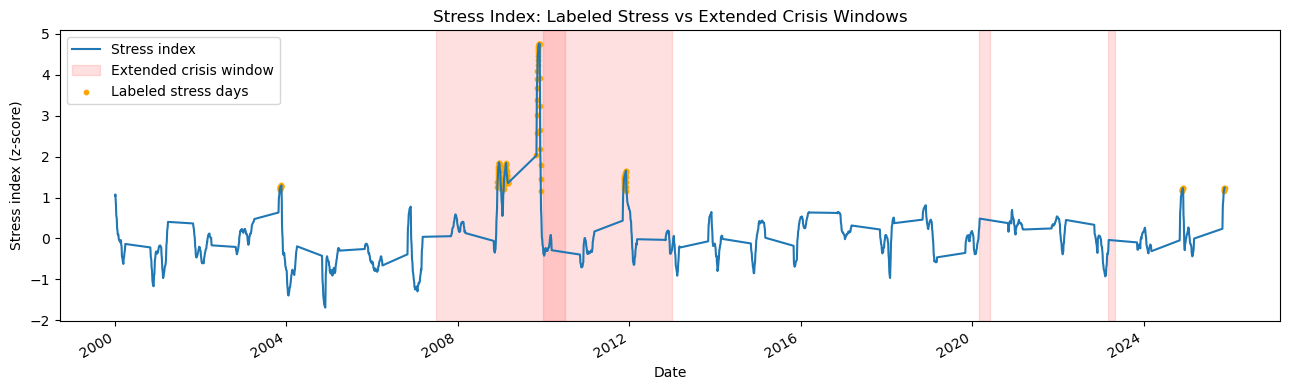

Saved crisis comparison figure to: /files/bank_stress_detection_project_datascience_class/results/figures/stress_index_extended_crisis_comparison.png

Notebook 03 finished.


In [8]:
# --- Cell 8: Plot stress index with known crisis windows and labels ---

fig, ax = plt.subplots(figsize=(13, 4))
stress_series.plot(ax=ax, color="tab:blue", label="Stress index")

first_window = True
for start_str, end_str in CRISIS_WINDOWS_EXTENDED:
    s = pd.to_datetime(start_str)
    e = pd.to_datetime(end_str)
    label = "Extended crisis window" if first_window else "_nolegend_"
    ax.axvspan(s, e, color="red", alpha=0.12, label=label)
    first_window = False

ax.scatter(
    stress_series.index[labels_main["stress_label"] == 1],
    stress_series[labels_main["stress_label"] == 1],
    color="orange",
    s=10,
    label="Labeled stress days",
)

ax.set_title("Stress Index: Labeled Stress vs Extended Crisis Windows")
ax.set_xlabel("Date")
ax.set_ylabel("Stress index (z-score)")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper left")

fig.tight_layout()
crisis_fig_path = RESULTS_DIR / "stress_index_extended_crisis_comparison.png"
fig.savefig(crisis_fig_path, dpi=150)
plt.show()

print("Saved crisis comparison figure to:", crisis_fig_path)
print("\nNotebook 03 finished.")